In [155]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('gym_members_exercise_tracking.csv')

df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [156]:
# Enhanced preprocessing script for the gym members dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('gym_members_exercise_tracking.csv')  # Load the raw dataset

# Check for missing values
missing_values = df.isnull().sum()  # Count missing values in each column

# Handle missing values
# Identify numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns 
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns 

# Fill missing numeric values with median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median()) 
# Fill missing categorical values with mode
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0]) 


# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['Gender', 'Workout_Type'], drop_first=True)  


# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 
                      'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)', 
                      'Workout_Frequency (days/week)', 'BMI']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])  
# Scale numerical features

# Feature Engineering
df_encoded['Heart_Rate_Zone'] = pd.cut(df['Max_BPM'], bins=[0, 120, 160, 200], labels=['Fat-Burning', 'Cardio', 'Peak'])  # Add heart rate zone feature
df_encoded['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 50], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])  # Add BMI category feature
df_encoded['Activity_Score'] = df['Workout_Frequency (days/week)'] * df['Session_Duration (hours)']  # Add activity score

# Encode new categorical features
df_encoded = pd.get_dummies(df_encoded, columns=['Heart_Rate_Zone', 'BMI_Category'], drop_first=True)  
# Encode new categorical features

# Save the enhanced processed dataset
processed_file_path = 'enhanced_processed_gym_data.csv'  # Filepath for the processed dataset
df_encoded.to_csv(processed_file_path, index=False)  # Save the processed dataset to a CSV file

# Display a sample of the processed data
from tabulate import tabulate
print(tabulate(df_encoded.head(), headers='keys', tablefmt='psql'))  # Display the first few rows for verification




+----+------------+---------------+--------------+------------+-----------+---------------+----------------------------+-------------------+------------------+-------------------------+---------------------------------+--------------------+------------+---------------+---------------------+-------------------------+---------------------+------------------+--------------------------+------------------------+-----------------------+---------------------------+----------------------+
|    |        Age |   Weight (kg) |   Height (m) |    Max_BPM |   Avg_BPM |   Resting_BPM |   Session_Duration (hours) |   Calories_Burned |   Fat_Percentage |   Water_Intake (liters) |   Workout_Frequency (days/week) |   Experience_Level |        BMI | Gender_Male   | Workout_Type_HIIT   | Workout_Type_Strength   | Workout_Type_Yoga   |   Activity_Score | Heart_Rate_Zone_Cardio   | Heart_Rate_Zone_Peak   | BMI_Category_Normal   | BMI_Category_Overweight   | BMI_Category_Obese   |
|----+------------+---------

Visualizing class distribution before and after splitting:
For this dataset, understanding class distribution helps ensure that the 'Low Activity' and 'High Activity' classes are proportionally represented.
A balanced representation ensures fair training of the SVM model, especially for predicting rare classes like 'High Activity'.


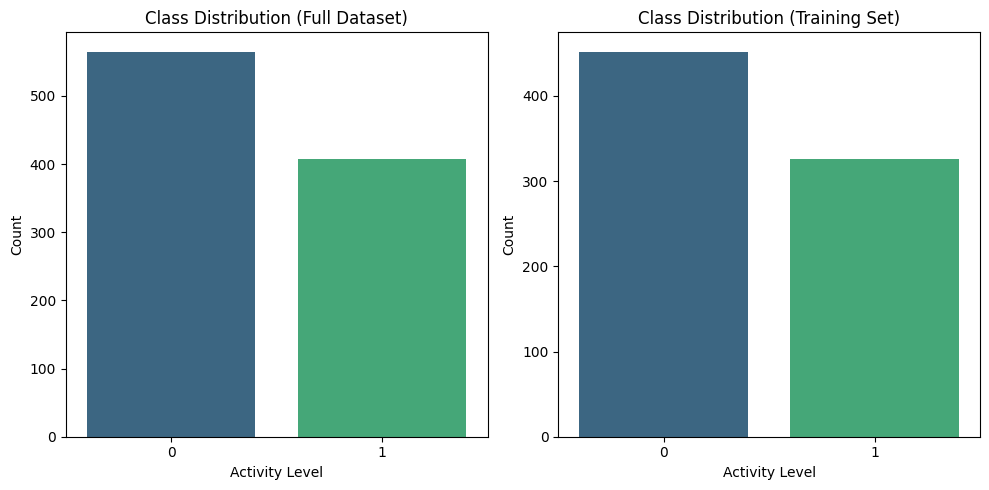

Accuracy: 0.81
Metrics per class:
  Low Activity - Precision: 0.96, Recall: 0.70, F1-Score: 0.81
  High Activity - Precision: 0.70, Recall: 0.96, F1-Score: 0.81
Visualizing the confusion matrix:
In this dataset, the confusion matrix reveals how well the SVM predicts gym members' activity levels.
We can identify whether 'Low Activity' individuals are being misclassified as 'High Activity' (or vice versa).


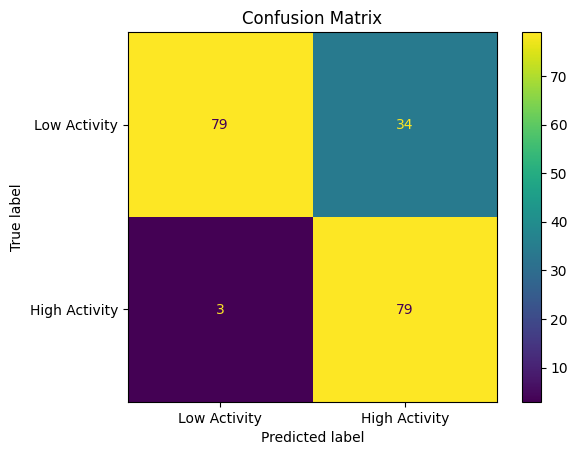

Visualizing the ROC curve:
For this dataset, the ROC curve helps assess the tradeoff between sensitivity (recall for 'High Activity') and false positive rate (incorrectly classifying 'Low Activity' as 'High Activity').


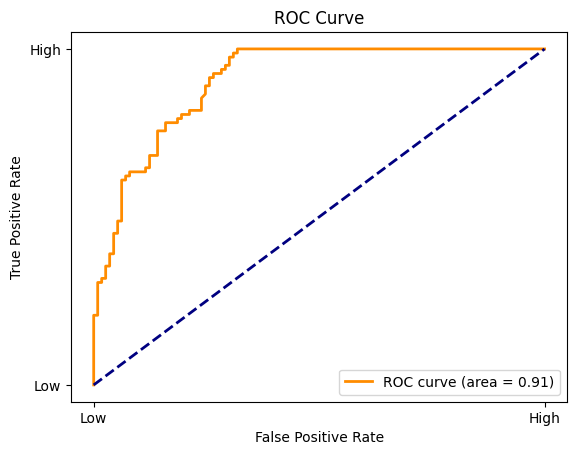

Visualizing the Precision-Recall curve:
In this dataset, the curve highlights how well the SVM balances between identifying 'High Activity' cases and avoiding false positives (precision).


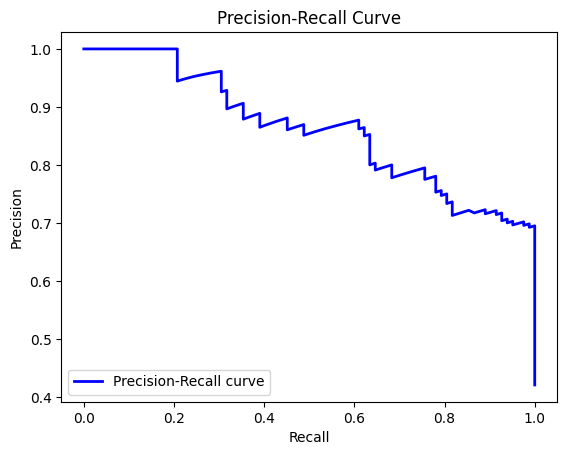

Visualizing the correlation heatmap:
For this dataset, the correlation heatmap helps identify relationships among gym members' attributes (e.g., BMI and age).
This can inform feature engineering or detect multicollinearity that might affect model performance.


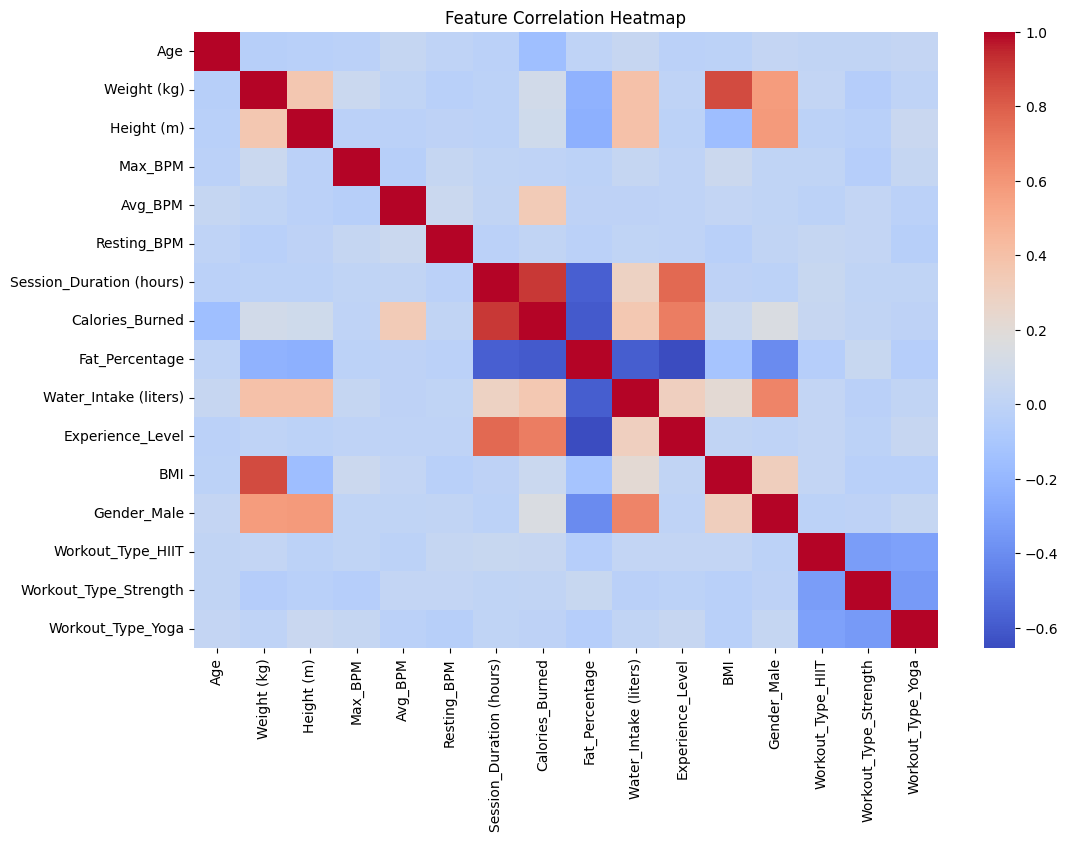

In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = 'gym_members_exercise_tracking.csv'  # Update to your file path
df = pd.read_csv(file_path)

# Define binary activity levels
def binary_activity_level_category(frequency):
    return 0 if frequency < 4 else 1  # Low Activity (<4) vs High Activity (>=4)

df['Activity_Level'] = df['Workout_Frequency (days/week)'].apply(binary_activity_level_category)

# Define features and target
X = df.drop(columns=['Workout_Frequency (days/week)', 'Activity_Level'])
y = df['Activity_Level']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Normalize numerical features
numerical_features = X_encoded.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_encoded[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

# Split the dataset with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Print explanation for class distribution visualization
print("Visualizing class distribution before and after splitting:")
print("For this dataset, understanding class distribution helps ensure that the 'Low Activity' and 'High Activity' classes are proportionally represented.")
print("A balanced representation ensures fair training of the SVM model, especially for predicting rare classes like 'High Activity'.")
# Visualize class distribution before and after splitting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y, hue=y, palette='viridis', legend=False)
plt.title("Class Distribution (Full Dataset)")
plt.xlabel("Activity Level")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train, hue=y_train, palette='viridis', legend=False)
plt.title("Class Distribution (Training Set)")
plt.xlabel("Activity Level")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Assign class weights for balanced training
class_weights = {cls: len(y_train) / (len(y_train.unique()) * (y_train == cls).sum()) for cls in y_train.unique()}

# Train the SVM model
svm_model = SVC(C=1, gamma=0.1, kernel='rbf', class_weight=class_weights, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)
y_pred_proba = svm_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Low Activity', 'High Activity'], output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display concise metrics
print(f"Accuracy: {accuracy:.2f}")
print("Metrics per class:")
for label, metrics in zip(['Low Activity', 'High Activity'], [report['Low Activity'], report['High Activity']]):
    print(f"  {label} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-Score: {metrics['f1-score']:.2f}")

# Print explanation for confusion matrix
print("Visualizing the confusion matrix:")
print("In this dataset, the confusion matrix reveals how well the SVM predicts gym members' activity levels.")
print("We can identify whether 'Low Activity' individuals are being misclassified as 'High Activity' (or vice versa).")
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Low Activity', 'High Activity'])
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()

# Print explanation for ROC curve
print("Visualizing the ROC curve:")
print("For this dataset, the ROC curve helps assess the tradeoff between sensitivity (recall for 'High Activity') and false positive rate (incorrectly classifying 'Low Activity' as 'High Activity').")
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot(["Low", "High"], ["Low", "High"], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Print explanation for precision-recall curve
print("Visualizing the Precision-Recall curve:")
print("In this dataset, the curve highlights how well the SVM balances between identifying 'High Activity' cases and avoiding false positives (precision).")
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(recall, precision, lw=2, color='blue', label="Precision-Recall curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# Print explanation for correlation heatmap
print("Visualizing the correlation heatmap:")
print("For this dataset, the correlation heatmap helps identify relationships among gym members' attributes (e.g., BMI and age).")
print("This can inform feature engineering or detect multicollinearity that might affect model performance.")
# Correlation Heatmap for Feature Relationships
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X_encoded).corr(), annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.show()
